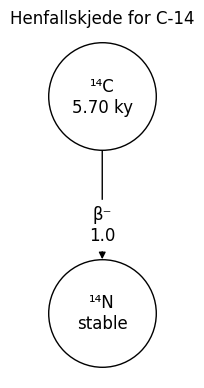

In [3]:
# Alfa, beta og gamma, samt halveringstid kalkulator 
"""
Fysikkmester GUI – interaktivt verktøy for kjernereaksjoner og halveringstid.
- Fanen "Henfall": skriv inn A og Z, velg strålingstype (alfa/β-/β+/γ), få nytt grunnstoff/isotop og forklaring.
- Fanen "Halveringstid": velg isotop fra nedtrekk, oppgi antall halveringer og startmasse -> gjenstående masse + tid.
- Valgfritt: Integrasjon med 'radioactivedecay' (hvis installert) for kjedediagram og eksakte halveringstider.

Avhenger kun av standardbibliotek + Tkinter. 'radioactivedecay' er valgfritt.
"""

import math
import tkinter as tk
from tkinter import ttk, messagebox

# ---------------------------------------------------
# Valgfri integrasjon med radioactivedecay
# ---------------------------------------------------
RD_AVAILABLE = False
try:
    import radioactivedecay as rd  # type: ignore
    RD_AVAILABLE = True
except Exception:
    RD_AVAILABLE = False

# ---------------------------------------------------
# Periodetabell (Z -> symbol) og omvendt
# ---------------------------------------------------
ELEMENT_SYMBOLS = [
    None,
    "H","He","Li","Be","B","C","N","O","F","Ne",
    "Na","Mg","Al","Si","P","S","Cl","Ar","K","Ca",
    "Sc","Ti","V","Cr","Mn","Fe","Co","Ni","Cu","Zn",
    "Ga","Ge","As","Se","Br","Kr","Rb","Sr","Y","Zr",
    "Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn",
    "Sb","Te","I","Xe","Cs","Ba","La","Ce","Pr","Nd",
    "Pm","Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb",
    "Lu","Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg",
    "Tl","Pb","Bi","Po","At","Rn","Fr","Ra","Ac","Th",
    "Pa","U","Np","Pu","Am","Cm","Bk","Cf","Es","Fm",
    "Md","No","Lr","Rf","Db","Sg","Bh","Hs","Mt","Ds",
    "Rg","Cn","Nh","Fl","Mc","Lv","Ts","Og"
]
SYMBOL_TO_Z = {sym: z for z, sym in enumerate(ELEMENT_SYMBOLS) if sym}

# ---------------------------------------------------
# Partikler
# ---------------------------------------------------
class Partikkel:
    def __init__(self, navn, A, Z, symbol):
        self.navn = navn
        self._A = A
        self._Z = Z
        self.symbol = symbol
    def A(self): return self._A
    def Z(self): return self._Z

PROTON  = Partikkel("proton", 1, +1, "p")
NEUTRON = Partikkel("nøytron", 1,  0, "n")
ALFA    = Partikkel("alfa",    4, +2, "α")
E_M     = Partikkel("elektron (beta-)", 0, -1, "e-")
E_P     = Partikkel("positron (beta+)", 0, +1, "e+")
GAMMA   = Partikkel("gamma",   0,  0, "γ")
NU_E    = Partikkel("elektron-nøytrino", 0, 0, "ν_e")
A_NU_E  = Partikkel("anti-elektron-nøytrino", 0, 0, "ν̄_e")

# ---------------------------------------------------
# Henfallsregler
# ---------------------------------------------------
def z_to_symbol(Z: int) -> str:
    return ELEMENT_SYMBOLS[Z] if 1 <= Z < len(ELEMENT_SYMBOLS) else "?"

def make_isotope(Z: int, A: int) -> str:
    if A <= 0 or Z < 0 or Z >= len(ELEMENT_SYMBOLS):
        raise ValueError(f"Ugyldig kjerne (A={A}, Z={Z}).")
    sym = z_to_symbol(Z)
    if sym == "?":
        raise ValueError(f"Ukjent grunnstoff for Z={Z}.")
    return f"{sym}-{A}"

def do_alpha(A: int, Z: int):
    if A < 5 or Z < 3:
        raise ValueError("Alfa-henfall krever A≥5 og Z≥3.")
    A2, Z2 = A - 4, Z - 2
    isotop = make_isotope(Z2, A2)
    forklaring = (f"Alfa (α): {z_to_symbol(Z)}-{A} → {isotop} + α\n"
                  f"A: {A}→{A2} (−4), Z: {Z}→{Z2} (−2), N: {A-Z}→{A2-Z2} (−2).")
    return isotop, forklaring

def do_beta_minus(A: int, Z: int):
    A2, Z2 = A, Z + 1
    isotop = make_isotope(Z2, A2)
    forklaring = (f"Beta- (β⁻): {z_to_symbol(Z)}-{A} → {isotop} + e⁻ + ν̄ₑ\n"
                  f"A uendret, Z: {Z}→{Z2} (+1), N: {A-Z}→{A2-Z2} (−1).")
    return isotop, forklaring

def do_beta_plus(A: int, Z: int):
    if Z < 1:
        raise ValueError("Beta+ krever Z≥1.")
    A2, Z2 = A, Z - 1
    isotop = make_isotope(Z2, A2)
    forklaring = (f"Beta+ (β⁺): {z_to_symbol(Z)}-{A} → {isotop} + e⁺ + νₑ\n"
                  f"A uendret, Z: {Z}→{Z2} (−1), N: {A-Z}→{A2-Z2} (+1).\n"
                  f"*Merk:* β⁺ krever energioverskudd eller elektroninnfangning i praksis.")
    return isotop, forklaring

def do_gamma(A: int, Z: int):
    isotop = make_isotope(Z, A)
    forklaring = (f"Gamma (γ): {z_to_symbol(Z)}-{A}* → {isotop} + γ\n"
                  f"A, Z, N uendret (de-eksitasjon).")
    return isotop, forklaring

# ---------------------------------------------------
# Halveringstid-data (fallback) i sekunder
# Oppdateres automatisk dersom radioactivedecay finnes.
# ---------------------------------------------------
FALLBACK_T12_S = {
    "C-14": 5730 * 365.25 * 24*3600,
    "U-238": 4.468e9 * 365.25 * 24*3600,
    "Co-60": 5.2714 * 365.25 * 24*3600,
    "I-131": 8.0197 * 24*3600,
    "Cs-137": 30.17 * 365.25 * 24*3600,
    "Rn-222": 3.8235 * 24*3600,
    "K-40": 1.251e9 * 365.25 * 24*3600,
    "Sr-90": 28.90 * 365.25 * 24*3600,
    "Po-210": 138.376 * 24*3600,
    "Ra-226": 1600 * 365.25 * 24*3600,
    "Na-22": 2.6018 * 365.25 * 24*3600,
    "Th-232": 1.405e10 * 365.25 * 24*3600,
}

ISOTOP_LISTE = list(FALLBACK_T12_S.keys())  # rekkefølge i nedtrekk

def rd_half_life_readable(nuclide: str) -> str:
    """Hent halveringstid som lesbar streng fra radioactivedecay om mulig."""
    if RD_AVAILABLE:
        try:
            return rd.Nuclide(nuclide).half_life("readable")
        except Exception:
            pass
    # Fallback: grov lesbar formattering
    secs = FALLBACK_T12_S.get(nuclide)
    if secs is None:
        return "ukjent"
    return human_readable_time(secs)

def rd_half_life_seconds(nuclide: str) -> float:
    """Halveringstid i sekunder (radioactivedecay hvis mulig, ellers fallback)."""
    if RD_AVAILABLE:
        try:
            return float(rd.Nuclide(nuclide).half_life("s"))
        except Exception:
            pass
    return float(FALLBACK_T12_S[nuclide])

def human_readable_time(seconds: float) -> str:
    """Gjør sekunder om til en kort lesbar streng."""
    units = [
        ("y", 365.25*86400),
        ("d", 86400),
        ("h", 3600),
        ("min", 60),
        ("s", 1),
    ]
    remaining = seconds
    parts = []
    for name, size in units:
        if remaining >= size:
            val = int(remaining // size)
            remaining -= val * size
            parts.append(f"{val} {name}")
        if len(parts) >= 2 and name != "s":  # hold det kort (to ledd)
            break
    if not parts:
        return f"{seconds:.3g} s"
    return " ".join(parts)

# ---------------------------------------------------
# GUI
# ---------------------------------------------------
class FysikkmesterApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Fysikkmester – Kjernereaksjoner og halveringstid")
        self.geometry("800x600")
        self.minsize(760, 560)

        nb = ttk.Notebook(self)
        self.tab_henfall = ttk.Frame(nb)
        self.tab_halv = ttk.Frame(nb)
        nb.add(self.tab_henfall, text="Henfall (A, Z → ny isotop)")
        nb.add(self.tab_halv, text="Halveringstid (nedtrekk)")
        nb.pack(fill="both", expand=True)

        self.build_henfall_tab()
        self.build_halvering_tab()

    # ---------------- Henfall-fanen ----------------
    def build_henfall_tab(self):
        frm = ttk.Frame(self.tab_henfall, padding=12)
        frm.pack(fill="both", expand=True)

        # Inndata A og Z
        box = ttk.LabelFrame(frm, text="Inndata for kjerne")
        box.pack(fill="x", pady=6)

        ttk.Label(box, text="Nukleontall A:").grid(row=0, column=0, sticky="w", padx=6, pady=6)
        self.var_A = tk.StringVar(value="238")
        spin_A = ttk.Spinbox(box, from_=1, to=1000, textvariable=self.var_A, width=8)
        spin_A.grid(row=0, column=1, padx=6, pady=6)

        ttk.Label(box, text="Protontall Z (atomnummer):").grid(row=0, column=2, sticky="w", padx=6, pady=6)
        self.var_Z = tk.StringVar(value="92")
        spin_Z = ttk.Spinbox(box, from_=0, to=118, textvariable=self.var_Z, width=8, command=self.update_symbol)
        spin_Z.grid(row=0, column=3, padx=6, pady=6)

        ttk.Label(box, text="Element:").grid(row=0, column=4, sticky="e", padx=6, pady=6)
        self.lbl_symbol = ttk.Label(box, text="Uran (U)")
        self.lbl_symbol.grid(row=0, column=5, sticky="w", padx=6, pady=6)

        # Valg av strålingstype
        box2 = ttk.LabelFrame(frm, text="Velg strålingstype")
        box2.pack(fill="x", pady=6)
        self.var_mode = tk.StringVar(value="alfa")
        ttk.Radiobutton(box2, text="Alfa (α)", variable=self.var_mode, value="alfa").grid(row=0, column=0, padx=6, pady=6, sticky="w")
        ttk.Radiobutton(box2, text="Beta- (β⁻)", variable=self.var_mode, value="beta-").grid(row=0, column=1, padx=6, pady=6, sticky="w")
        ttk.Radiobutton(box2, text="Beta+ (β⁺)", variable=self.var_mode, value="beta+").grid(row=0, column=2, padx=6, pady=6, sticky="w")
        ttk.Radiobutton(box2, text="Gamma (γ)", variable=self.var_mode, value="gamma").grid(row=0, column=3, padx=6, pady=6, sticky="w")

        btn = ttk.Button(frm, text="Beregn henfall", command=self.calc_decay)
        btn.pack(pady=8)

        self.txt_out = tk.Text(frm, height=14, wrap="word")
        self.txt_out.pack(fill="both", expand=True, pady=6)
        self.txt_out.configure(state="disabled")

        self.update_symbol()

    def update_symbol(self):
        try:
            Z = int(self.var_Z.get())
            sym = z_to_symbol(Z)
            navn = {
                "H":"Hydrogen","He":"Helium","Li":"Litium","Be":"Beryllium","B":"Bor","C":"Karbon","N":"Nitrogen","O":"Oksygen","F":"Fluor","Ne":"Neon",
                "Na":"Natrium","Mg":"Magnesium","Al":"Aluminium","Si":"Silisium","P":"Fosfor","S":"Svovel","Cl":"Klor","Ar":"Argon","K":"Kalium","Ca":"Kalsium",
                "Fe":"Jern","Ni":"Nikkel","Cu":"Kopper","Zn":"Sink","Ga":"Gallium","Ge":"Germanium","As":"Arsen","Se":"Selen","Br":"Brom","Kr":"Krypton",
                "Rb":"Rubidium","Sr":"Strontium","Y":"Yttrium","Zr":"Zirkonium","Nb":"Niob","Mo":"Molybden","Tc":"Teknetium","Ru":"Ruthenium","Rh":"Rodium","Pd":"Palladium",
                "Ag":"Sølv","Cd":"Kadmium","In":"Indium","Sn":"Tinn","Sb":"Antimon","Te":"Tellur","I":"Jod","Xe":"Xenon","Cs":"Cesium","Ba":"Barium",
                "La":"Lantan","Ce":"Cerium","Pr":"Praseodym","Nd":"Neodym","Pm":"Prometium","Sm":"Samarium","Eu":"Europium","Gd":"Gadolinium","Tb":"Terbium","Dy":"Dysprosium",
                "Ho":"Holmium","Er":"Erbium","Tm":"Tulium","Yb":"Ytterbium","Lu":"Lutetium","Hf":"Hafnium","Ta":"Tantal","W":"Wolfram","Re":"Rhenium","Os":"Osmium",
                "Ir":"Iridium","Pt":"Platina","Au":"Gull","Hg":"Kvikksølv","Tl":"Tallium","Pb":"Bly","Bi":"Vismut","Po":"Polonium","At":"Astat","Rn":"Radon",
                "Fr":"Francium","Ra":"Radium","Ac":"Aktinium","Th":"Thorium","Pa":"Protaktinium","U":"Uran","Np":"Neptunium","Pu":"Plutonium"
            }.get(sym, sym)
            self.lbl_symbol.config(text=f"{navn} ({sym})" if sym!="?" else "Ukjent")
        except Exception:
            self.lbl_symbol.config(text="Ukjent")

    def calc_decay(self):
        self.txt_out.configure(state="normal")
        self.txt_out.delete("1.0", "end")
        try:
            A = int(self.var_A.get())
            Z = int(self.var_Z.get())
            if A <= 0 or Z < 0 or Z > A:
                raise ValueError("Sjekk at A>0 og 0 ≤ Z ≤ A.")
            mode = self.var_mode.get()
            if mode == "alfa":
                iso, info = do_alpha(A, Z)
                part = " + α"
            elif mode == "beta-":
                iso, info = do_beta_minus(A, Z)
                part = " + e⁻ + ν̄ₑ"
            elif mode == "beta+":
                iso, info = do_beta_plus(A, Z)
                part = " + e⁺ + νₑ"
            else:
                iso, info = do_gamma(A, Z)
                part = " + γ"

            start = f"{z_to_symbol(Z)}-{A}"
            likn = f"Reaksjon: {start} → {iso}{part}"
            self.txt_out.insert("end", likn + "\n" + info + "\n")
            self.txt_out.insert("end", f"Ny isotop/grunnstoff: {iso}\n")
            self.txt_out.insert("end", f"N (nøytroner): {A-Z} → {int(iso.split('-')[1]) - SYMBOL_TO_Z[iso.split('-')[0]]}\n")
        except Exception as e:
            messagebox.showerror("Feil i henfall", str(e))
        finally:
            self.txt_out.configure(state="disabled")

    # ---------------- Halveringstid-fanen ----------------
    def build_halvering_tab(self):
        frm = ttk.Frame(self.tab_halv, padding=12)
        frm.pack(fill="both", expand=True)

        line1 = ttk.Frame(frm)
        line1.pack(fill="x", pady=4)

        ttk.Label(line1, text="Velg isotop:").pack(side="left")
        self.iso_var = tk.StringVar(value=ISOTOP_LISTE[0])
        self.iso_combo = ttk.Combobox(line1, textvariable=self.iso_var, values=ISOTOP_LISTE, state="readonly", width=12)
        self.iso_combo.pack(side="left", padx=6)
        self.iso_combo.bind("<<ComboboxSelected>>", lambda e: self.update_halflife_label())

        ttk.Label(line1, text="Halveringstid:").pack(side="left", padx=(16, 4))
        self.lbl_t12 = ttk.Label(line1, text="")
        self.lbl_t12.pack(side="left")
        self.update_halflife_label()

        if RD_AVAILABLE:
            btn_chain = ttk.Button(line1, text="Vis kjedediagram", command=self.show_chain_plot)
            btn_chain.pack(side="right")

        line2 = ttk.Frame(frm)
        line2.pack(fill="x", pady=4)
        ttk.Label(line2, text="Startmasse:").grid(row=0, column=0, sticky="w")
        self.var_m = tk.StringVar(value="1.0")
        ttk.Entry(line2, textvariable=self.var_m, width=10).grid(row=0, column=1, padx=6)
        self.unit_var = tk.StringVar(value="kg")
        ttk.Combobox(line2, textvariable=self.unit_var, values=["kg","g","mg"], state="readonly", width=5)\
            .grid(row=0, column=2)

        ttk.Label(line2, text="Antall halveringer n:").grid(row=0, column=3, padx=(16,4))
        self.var_n = tk.StringVar(value="2")
        ttk.Spinbox(line2, from_=0, to=200, textvariable=self.var_n, width=6).grid(row=0, column=4)

        btn_calc = ttk.Button(frm, text="Beregn gjenstående masse", command=self.calc_mass_after_halflives)
        btn_calc.pack(pady=8)

        self.txt_halv = tk.Text(frm, height=16, wrap="word")
        self.txt_halv.pack(fill="both", expand=True, pady=4)
        self.txt_halv.configure(state="disabled")

        # Info
        info = ttk.Label(frm, foreground="#555",
                         text="Formel: N = N0 · 2^(-n). Forløpt tid = n · T1/2. (Arealutnyttelse: viser også T1/2 fra database hvis tilgjengelig.)")
        info.pack(anchor="w", pady=(2,0))

    def update_halflife_label(self):
        iso = self.iso_var.get()
        t12_str = rd_half_life_readable(iso)
        self.lbl_t12.config(text=t12_str)

    def calc_mass_after_halflives(self):
        self.txt_halv.configure(state="normal")
        self.txt_halv.delete("1.0", "end")
        try:
            iso = self.iso_var.get()
            n = float(self.var_n.get())
            m0 = float(self.var_m.get())
            unit = self.unit_var.get()
            # Konverter masse til kg internt
            factor = {"kg":1.0, "g":1e-3, "mg":1e-6}[unit]
            m0kg = m0 * factor
            frac = 2.0 ** (-n)   # N/N0
            mkg = m0kg * frac
            # tilbake til valgt enhet
            m_out = mkg / factor

            # Tid som har gått
            t12_s = rd_half_life_seconds(iso)
            t_elapsed_s = n * t12_s
            t_elapsed_str = human_readable_time(t_elapsed_s)
            t12_str = rd_half_life_readable(iso)

            self.txt_halv.insert("end", f"Isotop: {iso}\n")
            self.txt_halv.insert("end", f"Halveringstid T1/2: {t12_str}\n")
            self.txt_halv.insert("end", f"Antall halveringer n: {n:g}\n")
            self.txt_halv.insert("end", f"Startmasse: {m0:g} {unit}\n\n")
            self.txt_halv.insert("end", f"Gjenstående fraksjon: {frac:.6f}\n")
            self.txt_halv.insert("end", f"Gjenstående masse: {m_out:.6g} {unit}\n")
            self.txt_halv.insert("end", f"Forløpt tid: ~ {t_elapsed_str}\n")
        except Exception as e:
            messagebox.showerror("Feil i halveringsberegning", str(e))
        finally:
            self.txt_halv.configure(state="disabled")

    def show_chain_plot(self):
        if not RD_AVAILABLE:
            messagebox.showwarning("radioactivedecay mangler",
                                   "Installer pakken for å vise kjedediagram:\n\npip install radioactivedecay")
            return
        try:
            iso = self.iso_var.get()
            # Tegn kjedediagram i eget Matplotlib-vindu
            nuc = rd.Nuclide(iso)
            fig, ax = nuc.plot(label_pos=0.6)
            ax.set_title(f"Henfallskjede for {iso}")
            # Forsinket import for å unngå krav når RD ikke er tilgjengelig
            import matplotlib.pyplot as plt  # type: ignore
            plt.show()
        except Exception as e:
            messagebox.showerror("Kjedediagram", str(e))

if __name__ == "__main__":
    app = FysikkmesterApp()
    app.mainloop()